# Homework 1: Image Formation and Sensing

## Color image demosaicing

Recall that in digital cameras the red, blue, and green sensors are interlaced in a Bayer pattern. Your goal is to fill the missing values in each channel to obtain a full color image. For this homework, you will implement three different interpolation algorithms. The input to the algorithm is a single image *im*, an N x M array of numbers between 0.0 and 1.0. These are measurements in the format shown in Figure 2, i.e. the top left pixel *im(0, 0)* is red, *im(0, 1)* is green, *im(1, 0)* is also green and *im(1, 1)* refers to the blue channel. Your goal is to create a single color image from these measurements.

<img src="mosaic.png">

First, run the following code to load the input images.

In [1]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt

images = ['balloons.jpg', 'candy.jpg', 'cat.jpg', 'ip.jpg', 
          'puppy.jpg', 'squirrel.jpg', 'tree.jpg']

def show_image(img):
    plt.imshow(img, interpolation='nearest')

In [2]:
'''This array contains the mosaiced images which have to be demosaiced.'''
mosaiced_images = []
gtruth_images = []

'''A function to generate the mosaiced images from the given RGB images.'''
def generate_mosaic(image):
    mosaic = image[:, :, 1].copy() # green
    mosaic[::2, ::2] = image[::2, ::2, 0] # red
    mosaic[1::2, 1::2] = image[1::2, 1::2, 2] # blue
    return mosaic
        
'''A function to generate the mosaiced images for all the input images.'''
def generate_input(mosaiced_images, gtruth_images):
    for file in images:
        image = imread('input/' + file)
        image = image / 255.0
        gtruth_images.append(image)
        mosaiced_images.append(generate_mosaic(image))
        
generate_input(mosaiced_images, gtruth_images)

## Visualize the Images

To gain intuition, let's visualize the image encoded in the Bayer pattern. Run the code below to see both the mosaic image and the original image. In this problem, you will take the image encoded in a Bayer pattern and recover the full color image.

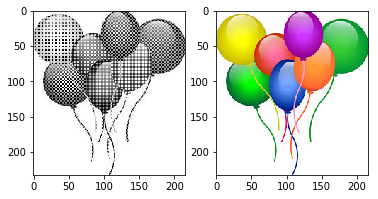

In [3]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(mosaiced_images[0], cmap='gray')
axarr[1].imshow(gtruth_images[0], cmap='gray')

## Implement your code here

There are several algorithms that we can use to recover the original image. You will implement three of them:

1) Implement the **nearest neighbour** (12 pt) algorithm

2) Implement the **linear interpolation** (12 pt) algorithm.

3) Then, implement a more advanced method such as the **adaptive gradient-based** (15 pt) algorithm, and compare the results.

These methods will be evaluated in the next section.

In [4]:
'''Methods to demosaic the image; the input is a mosaiced image and the output should be a
demosaiced image with R, G and B channels. The dimensions of the images should be the
same.'''

def demosaic_nn(im):
    '''
    Implement your nearest neighbour code here.
    '''
    demosaic = np.tile(np.expand_dims(im.copy(),-1),(1,1,3))

    r,c = demosaic.shape[0], demosaic.shape[1]

    # modify red channel

    for i in range(0,r,2):
        for j in range(0,c,2):
            if i+1 < r and j+1 < c:
                demosaic[i,j+1,0] = demosaic[i,j,0]
                demosaic[i+1,j,0] = demosaic[i,j,0]
                demosaic[i+1,j+1,0] = demosaic[i,j,0]
            elif j+1 < c:
                demosaic[i,j+1,0] = demosaic[i,j,0]
            elif i+1 < r:
                demosaic[i+1,j,0] = demosaic[i,j,0]

    # modify green channel

    for i in range(0,r,2):
        for j in range(1,c,2):
            demosaic[i,j-1,1] = demosaic[i,j,1]
        if c%2 == 1:
            demosaic[i,-1,1] = demosaic[i,-2,1]

    for i in range(1,r,2):
        for j in range(1,c,2):
            demosaic[i,j,1] = demosaic[i,j-1,1]       


    # modify blue channel

    for i in range(1,r,2):
        for j in range(1,c,2):
            demosaic[i-1,j-1,2] = demosaic[i,j,2]
            demosaic[i-1,j,2] = demosaic[i,j,2]
            demosaic[i,j-1,2] = demosaic[i,j,2]     

    if r%2 == 1:
        demosaic[-1,:,2] = demosaic[-2,:,2]

    if c%2 == 1:
        demosaic[:,-1,2] = demosaic[:,-2,2]
    
    return demosaic

def demosaic_interpolate(im):
    '''
    Implement your linear interpolation code here.
    '''
    r,c = im.shape[0], im.shape[1]

    demosaic = []

    # modify red 

    red = im.copy()
    if r%2 == 0:
        red = np.vstack([red,red[-2,:].reshape(1,c)])
    if c%2 == 0:
        red = np.hstack([red,red[:,-2].reshape(red.shape[0],1)])

    for i in range(0,red.shape[0]-2,2):
        for j in range(0,red.shape[1]-2,2):
            red[i+1,j] = (red[i,j] + red[i+2,j]) / 2
            red[i,j+1] = (red[i,j] + red[i,j+2]) / 2
            red[i+2,j+1] = (red[i+2,j] + red[i+2,j+2]) / 2
            red[i+1,j+2] = (red[i,j+2] + red[i+2,j+2]) / 2
            red[i+1,j+1] = (red[i,j] + red[i,j+2] + red[i+2,j] + red[i+2,j+2]) / 4

    demosaic.append(red[:r,:c])

    # modify green

    green = im.copy()
    if r%2 == 0:
        green = np.vstack([green,green[-2,:].reshape(1,c)])
    if c%2 == 0:
        green = np.hstack([green,green[:,-2].reshape(green.shape[0],1)])

    green[0,0] = (green[0,1] + green[1,0]) / 2
    green[0,-1] = (green[0,-2] + green[1,-1]) / 2
    green[-1,0] = (green[-2,0] + green[-1,1]) / 2
    green[-1,-1] = (green[-1,-2] + green[-2,-1]) / 2

    for i in range(2,green.shape[1]-2,2):
        green[0,i] = (green[0,i-1] + green[0,i+1] + green[1,i]) / 3
        green[-1,i] = (green[-1,i-1] + green[-1,i+1] + green[-2,i]) / 3

    for i in range(2,green.shape[0]-2,2):
        green[i,0] = (green[i-1,0] + green[i+1,0] + green[i,1]) / 3
        green[i,-1] = (green[i-1,-1] + green[i+1,-1] + green[i,-2]) / 3

    for i in range(1,green.shape[0]-1,2):
        for j in range(1,green.shape[1]-1,2):
            green[i,j] = (green[i-1,j] + green[i+1,j] + green[i,j-1] + green[i,j+1]) / 4

    for i in range(2,green.shape[0]-2,2):
        for j in range(2,green.shape[1]-2,2):
            green[i,j] = (green[i-1,j] + green[i+1,j] + green[i,j-1] + green[i,j+1]) / 4

    demosaic.append(green[:r,:c])  

    # modify blue

    blue = im.copy()
    if r%2 == 0:
        blue = np.vstack([blue,blue[-2,:].reshape(1,c)])
    if c%2 == 0:
        blue = np.hstack([blue,blue[:,-2].reshape(blue.shape[0],1)])

    for i in range(1,blue.shape[0]-3,2):
        for j in range(1,blue.shape[1]-3,2):
            blue[i,j+1] = (blue[i,j]+blue[i,j+2]) / 2
            blue[i+1,j] = (blue[i,j]+blue[i+2,j]) / 2
            blue[i+1,j+2] = (blue[i,j+2]+blue[i+2,j+2]) / 2
            blue[i+2,j+1] = (blue[i+2,j]+blue[i+2,j+2]) / 2
            blue[i+1,j+1] = (blue[i,j]+blue[i,j+2]+blue[i+2,j]+blue[i+2,j+2]) / 4

    for i in range(1,blue.shape[0]-1):
        blue[i,0] = 2*blue[i,1] - blue[i,2]
        blue[i,-1] = 2*blue[i,-2] - blue[i,-3]

    for i in range(1,blue.shape[1]-1):
        blue[0,i] = 2*blue[1,i] - blue[2,i]
        blue[-1,i] = 2*blue[-2,i] - blue[-3,i]

    blue[0,0] = (blue[1,0] + blue[0,1]) / 2
    blue[0,-1] = (blue[0,-2]+ blue[1,-1]) / 2
    blue[-1,0] = (blue[-1,1] + blue[-2,0]) / 2
    blue[-1,-1] = (blue[-1,-2] + blue[-2,-1]) / 2

    demosaic.append(blue[:r,:c])

    demosaic = np.stack(demosaic,axis=-1)
    demosaic = np.clip(demosaic,0,1)
    
    
    return demosaic

def demosaic_gradient(im):
    '''
    Implement your gradient-based code here.
    '''
    
    r,c = im.shape[0], im.shape[1]

    demosaic = []

    # modify red 

    red = im.copy()
    if r%2 == 0:
        red = np.vstack([red,red[-2,:].reshape(1,c)])
    if c%2 == 0:
        red = np.hstack([red,red[:,-2].reshape(red.shape[0],1)])

    for i in range(0,red.shape[0]-2,2):
        for j in range(0,red.shape[1]-2,2):
            red[i+1,j] = (red[i,j] + red[i+2,j]) / 2
            red[i,j+1] = (red[i,j] + red[i,j+2]) / 2
            red[i+2,j+1] = (red[i+2,j] + red[i+2,j+2]) / 2
            red[i+1,j+2] = (red[i,j+2] + red[i+2,j+2]) / 2
            if np.abs(red[i,j] - red[i+2, j+2]) > np.abs(red[i,j+2] - red[i+2,j]):
                red[i+1,j+1] = (red[i,j+2] + red[i+2,j]) / 2
            else:
                red[i+1,j+1] = (red[i,j] + red[i+2,j+2]) / 2

    demosaic.append(red[:r,:c])

    # modify green

    green = im.copy()
    if r%2 == 0:
        green = np.vstack([green,green[-2,:].reshape(1,c)])
    if c%2 == 0:
        green = np.hstack([green,green[:,-2].reshape(green.shape[0],1)])

    green[0,0] = (green[0,1] + green[1,0]) / 2
    green[0,-1] = (green[0,-2] + green[1,-1]) / 2
    green[-1,0] = (green[-2,0] + green[-1,1]) / 2
    green[-1,-1] = (green[-1,-2] + green[-2,-1]) / 2

    for i in range(2,green.shape[1]-2,2):
        green[0,i] = (green[0,i-1] + green[0,i+1] + green[1,i]) / 3
        green[-1,i] = (green[-1,i-1] + green[-1,i+1] + green[-2,i]) / 3

    for i in range(2,green.shape[0]-2,2):
        green[i,0] = (green[i-1,0] + green[i+1,0] + green[i,1]) / 3
        green[i,-1] = (green[i-1,-1] + green[i+1,-1] + green[i,-2]) / 3

    for i in range(1,green.shape[0]-1,2):
        for j in range(1,green.shape[1]-1,2):
            if np.abs(green[i,j-1]-green[i,j+1]) > np.abs(green[i-1,j]-green[i+1,j]):
                green[i,j] = (green[i-1,j] + green[i+1,j]) / 2
            else:
                green[i,j] = (green[i,j-1] + green[i,j+1]) / 2

    for i in range(2,green.shape[0]-2,2):
        for j in range(2,green.shape[1]-2,2):
            if np.abs(green[i,j-1]-green[i,j+1]) > np.abs(green[i-1,j]-green[i+1,j]):
                green[i,j] = (green[i-1,j] + green[i+1,j]) / 2
            else:
                green[i,j] = (green[i,j-1] + green[i,j+1]) / 2

    demosaic.append(green[:r,:c])  

    # modify blue

    blue = im.copy()
    if r%2 == 0:
        blue = np.vstack([blue,blue[-2,:].reshape(1,c)])
    if c%2 == 0:
        blue = np.hstack([blue,blue[:,-2].reshape(blue.shape[0],1)])

    for i in range(1,blue.shape[0]-3,2):
        for j in range(1,blue.shape[1]-3,2):
            blue[i,j+1] = (blue[i,j]+blue[i,j+2]) / 2
            blue[i+1,j] = (blue[i,j]+blue[i+2,j]) / 2
            blue[i+1,j+2] = (blue[i,j+2]+blue[i+2,j+2]) / 2
            blue[i+2,j+1] = (blue[i+2,j]+blue[i+2,j+2]) / 2
            if np.abs(blue[i,j] - blue[i+2,j+2]) > np.abs(blue[i,j+2] - blue[i+2,j]):
                blue[i+1,j+1] = (blue[i,j+2]+blue[i+2,j]) / 2
            else:
                blue[i+1,j+1] = (blue[i,j]+blue[i+2,j+2]) / 2

    for i in range(1,blue.shape[0]-1):
        blue[i,0] = 2*blue[i,1] - blue[i,2]
        blue[i,-1] = 2*blue[i,-2] - blue[i,-3]

    for i in range(1,blue.shape[1]-1):
        blue[0,i] = 2*blue[1,i] - blue[2,i]
        blue[-1,i] = 2*blue[-2,i] - blue[-3,i]

    blue[0,0] = (blue[1,0] + blue[0,1]) / 2
    blue[0,-1] = (blue[0,-2]+ blue[1,-1]) / 2
    blue[-1,0] = (blue[-1,1] + blue[-2,0]) / 2
    blue[-1,-1] = (blue[-1,-2] + blue[-2,-1]) / 2

    demosaic.append(blue[:r,:c])

    demosaic = np.stack(demosaic,axis=-1)
    demosaic = np.clip(demosaic,0,1)
    
    return demosaic

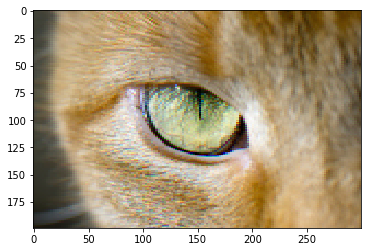

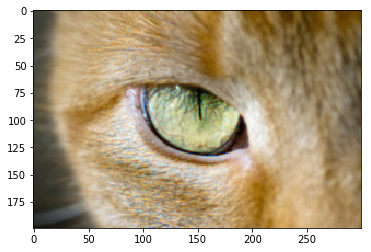

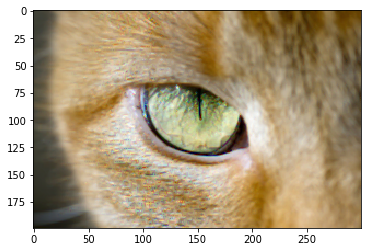

In [5]:
'''These lists will contain the output images of each of the demosaicing methods.'''
nn_output = []
interpolation_output = []
gradient_output = []

def demosaic_image(image, method='NN'):
    if method == 'NN':
        return demosaic_nn(image)
    elif method == 'interpolate':
        return demosaic_interpolate(image)
    elif method == 'gradient':
        return demosaic_gradient(image)
    else:
        raise ValueError('Unknown method')

def generate_output(mosaiced_images):
    
    # Demosaicing using the nearest neighbour method
    for image in mosaiced_images:
        op = demosaic_image(image, method='NN')
        nn_output.append(op)
        
    # Demosaicing using the linear interpolation method
    for image in mosaiced_images:
        op = demosaic_image(image, method='interpolate')
        interpolation_output.append(op)
        
    # Demosaicing using the gradient-based method
    for image in mosaiced_images:
        op = demosaic_image(image, method='gradient')
        gradient_output.append(op)
        
generate_output(mosaiced_images)

'''Modify the index of the image to show as an example here.'''
image_to_show = 2

plt.figure()
show_image(nn_output[image_to_show])
plt.figure()
show_image(interpolation_output[image_to_show])
plt.figure()
show_image(gradient_output[image_to_show])

## Evaluation



We will evaluate the algorithm by comparing your output to the ground truth color image. The input to your algorithm was constructed by artificially mosaicing it. This is not ideal in practice, but we will ignore this for now. We can compute the mean error between each color image and your output and report these numbers for each algorithm.

*Please note that just whether or not the mean errors lie below the threshold does not fully determine your grade; rather, they serve as an indication for you to check whether your algorithms perform correctly and to see which methods work better than others.*

In [6]:
def calculate_mean_difference(output_images):
    sum = 0.0
    for idx, image in enumerate(output_images):
        pixel_error = np.absolute(image - gtruth_images[idx])
        sum += np.mean(pixel_error)
    sum /= len(output_images)
    
    return sum
    
def evaluate(threshold):
    error = calculate_mean_difference(nn_output)
    if  error < threshold:
        print("NN -> Likely passed! Mean error is", error)
    else:
        print("NN -> Failed! Mean error is", error)
       
    error = calculate_mean_difference(interpolation_output)
    if  error < threshold:
        print("Interpolation -> Likely passed! Mean error is", error)
    else:
        print("Interpolation -> Failed! Mean error is", error)
    
    error = calculate_mean_difference(gradient_output)
    if  error < threshold:
        print("Gradient -> Likely passed! Mean error is", error)
    else:
        print("Gradient -> Failed! Mean error is", error)

evaluate(threshold=0.03)

NN -> Likely passed! Mean error is 0.02552320137102246
Interpolation -> Likely passed! Mean error is 0.015659640095313586
Gradient -> Likely passed! Mean error is 0.01454858795483858


*This homework was designed by Varun Chanddra and Basile Van Hoorick under the supervision of Prof. Carl Vondrick. It is based on a homework from the class EECS 442 by Prof. Jia Deng at the University of Michigan, Ann Arbor, which was in turn taken from the class CMPSCI 670 by Prof. Subhransu Maji at the University of Massachusetts, Amherst.*